# Project 2 - Polynomial Models for Boston House Prices

## Group members
   Michael Peralta ()
   
   Brandon Xue (brandonx@csu.fullerton.edu)

### CPSC 483-02, Section ID: 33018

In [94]:
# 1. Load and examine
import pandas as pd
from sklearn.datasets import *

bs = load_boston()
bs.DESCR # description
bs.data # features
bs.target # targets
bs.feature_names # feature names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [95]:
# 2. Partition into training and testing sets

from sklearn import model_selection
data_with_targets = zip(bs.data, bs.target)

bs_df = pd.DataFrame(data=bs.data, columns=bs.feature_names)

# Add targets to same data frame so they stay paired with other data
bs_df.insert(len(bs_df.columns), 'TARGET', bs.target)

# train_test_split returns a list of the train-test split of inputs
train, test = model_selection.train_test_split(bs_df, train_size=0.8)

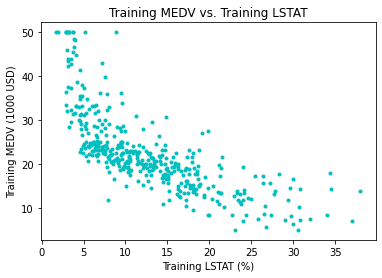

In [96]:
# 3. Scatter plot of training data
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(train.LSTAT, train.TARGET, 'c.')
retval = ax.set(xlabel="Training LSTAT (%)", ylabel="Training MEDV (1000 USD)",
                title="Training MEDV vs. Training LSTAT")